# Evaluation des Neuronalen Netzes zur Giraffenpuzzle-Erkennung
Das Notebook [Giraffenpuzzle-Training](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-training?scriptVersionId=187781292) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Giraffenpuzzleteile-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

In [1]:
import matplotlib.pyplot as plt #Plottingroutinen zur Visualisierung
import numpy as np # Arrays- "The fundamental package for scientific computing with Python" 
import pandas as pd #Umgang mit Tabellen- hier nur zum Laden der Klassenlabels
import tensorflow as tf #Tensorflow, trainieren von neuronale Netzen (inkl. Keras)
import shutil # Dateisystemmanipulationen, insbesondere für das Kopieren von Dateien
from pathlib import Path #Pathlib, Umgang mit Dateipfaden
import scikitplot # Visualisierungen von Klassifikationsperformanz

In [2]:
# Modell laden:
loaded_model = tf.keras.models.load_model('Training/working/model/model_Besteck.keras')
# Excel-Datei mit Angabe, ob ein Bild ein Test- oder ein Trainingsbild ist:
train_or_test = pd.read_excel('train_test_split.xlsx')
train_or_test.columns = ['Dateiname','TrainOrTest']

Hiermit haben wir die Zuordnung unserer Daten zu den Trainings- und Testdaten. Wir wollen hier nur noch Bilder, mit welchen das Modell nicht trainiert wurde.

In [3]:
train_or_test

,Dateiname,TrainOrTest
0,knife-big_1_03.jpg,train
1,fork-big_2_01.jpg,train
2,knife-big_3_12.jpg,train
3,fork-big_0_10.jpg,train
4,fork-big_0_04.jpg,train
...,...,...
135,spoon-big_0_11.jpg,test
136,spoon-big_0_05.jpg,test
137,spoon-big_0_04.jpg,test
138,spoon-big_0_10.jpg,test


Wir erstellen nun zwei Baumstrukturen (für Trainings- und Testdaten). Das Klassenlabel extrahieren wir aus dem Dateinamen- hier ist es alles vor dem ersten Underscore, "_".

In [4]:
# Extrahiere Klassenlabel aus Dateiname
Klassenlabel = train_or_test.Dateiname.map(lambda s:s[:s.find('_')])
train_or_test['Klasse'] = Klassenlabel

# Wähle nur die Testdaten
testbilder = train_or_test[ train_or_test['TrainOrTest']=='test' ]
y_test = Klassenlabel[ train_or_test['TrainOrTest']=='test' ]

# Kopiere die Testbilder in eine Baumstruktur
for irow,row in testbilder.iterrows():
    Dateiname,TrainOrTest,Klasse = (row.Dateiname,row.TrainOrTest,row.Klasse)
    fullfilename = Path('1_object_extraction_output/Ausschnitte')/Dateiname
    Baumstrukturpfad = Path('Training/working')/'test'
    (Baumstrukturpfad/Klasse).mkdir(exist_ok=True,parents=True)
    shutil.copyfile(fullfilename,Baumstrukturpfad/Klasse/Dateiname)

Überprüfen wir das Resultat:

In [5]:
!ls Training/working/test
#!ls /kaggle/working/test/*   #Ausgabe ist etwas lang, aber nützlich für die Überprüfung der Vollständigkeit
print('-'*70) #nur zur visuellen Strukturierung; 3*"a" ergibt "aaa"
!ls Training/working/test/fork-big

fork-big  knife-big spoon-big
----------------------------------------------------------------------
fork-big_0_08.jpg fork-big_1_05.jpg fork-big_3_04.jpg fork-big_5_06.jpg
fork-big_0_09.jpg fork-big_1_07.jpg fork-big_3_07.jpg fork-big_5_10.jpg
fork-big_1_01.jpg fork-big_1_11.jpg fork-big_3_10.jpg
fork-big_1_02.jpg fork-big_2_08.jpg fork-big_3_11.jpg
fork-big_1_04.jpg fork-big_2_09.jpg fork-big_5_03.jpg


tf.Dataset ist eine Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt.

In [6]:
image_size=(64,64)
batch_size=32
test_ds = tf.keras.utils.image_dataset_from_directory(
    Baumstrukturpfad,  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
    validation_split=0.0,
    #subset="validation",
    shuffle=False, # Das ist wichtig, da wir später die Bilder in der gleichen Reihenfolge aus dem Dataset extrahieren müssen, in der wir sie dem Modell zur prediction gefüttert haben.
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 57 files belonging to 3 classes.


Steht da in der letzten Zeile `Found 94 files belonging to 20 classes.`, o.ä.? Gut!
Laden wir diese Bilder nun als Numpy-Arrays. Es gibt andere Möglichkeiten, das gleiche zu erreichen, aber jedenfalls erhalten wir einen Numpy-Array mit den Dimensionen (Anzahl Bilder, 64,64, Anzahl Farbkanäle).

In [7]:
L = [x for x in test_ds] # wir extrahieren die Testbilder aus dem Dataset
#X_test = [x.numpy().shape for x,y in L]
X_test = np.vstack([x.numpy() for x,y in L])
y_test = np.hstack([y.numpy() for x,y in L])
X_test.shape,y_test.shape

2024-12-30 11:05:41.309261: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((57, 64, 64, 3), (57,))

Wir überprüfen, dass zumindest das erste Bild in Xtest dem ersten eintrag in der testbilder-Liste entspricht:

In [8]:
testbildname = sorted(testbilder.Dateiname)[0] # "[0]": erstes Bild
dfrow = testbilder[testbilder.Dateiname==testbildname]
testbildklasse = dfrow.Klasse.iloc[0]
dfrow

,Dateiname,TrainOrTest,Klasse
19,.DS_Store,test,.DS


In [9]:
testbild1 = plt.imread(Baumstrukturpfad/testbildklasse/testbildname)
plt.imshow(testbild1)
plt.title(testbildname);

UnidentifiedImageError: cannot identify image file '/Users/jan/Documents/Repos/DSCI_Projekt/Training/working/test/.DS/.DS_Store'

Das entsprechende Bild in `X_test` wurde zentriert, d.h. die Farben stimmen nicht mehr:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.9375].


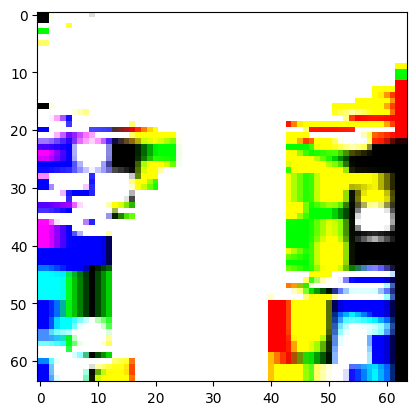

In [79]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0]);

Die obigen zwei Bilder könnten das gleiche Bild sein (jenes unten ist so, wie es das neuronale Netz in etwa sieht...). D.h. wir verstehen nun die Reihenfolge der Predictions: 

In [80]:
yhat_test = loaded_model.predict(X_test)
yhatnum_test = yhat_test.argmax(axis=1)
yhat_test.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


(57, 3)

In [81]:
y_test,yhatnum_test

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
 array([0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [82]:
Genauigkeit = np.mean(np.where(y_test==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 78.9%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [83]:
sorted_class_labels = np.array(sorted(Klassenlabel.unique())) #Labels in Keras der Funktion image_dataset_from_directory werden immer alphanummerisch sortiert den Indices zugeordnet
sorted_class_labels

array(['fork-big', 'knife-big', 'spoon-big'], dtype='<U9')

In [84]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test],index=testbilder.index)
y_test_label = pd.Series(sorted_class_labels[y_test],index=testbilder.index)
# das vorhergesagte Label:
yhat_label

74      fork-big
75     spoon-big
76     spoon-big
81      fork-big
83      fork-big
84      fork-big
85      fork-big
88     spoon-big
89      fork-big
90      fork-big
91      fork-big
92     spoon-big
93      fork-big
95     spoon-big
96     spoon-big
97     spoon-big
98      fork-big
99     knife-big
100    knife-big
101    knife-big
102     fork-big
103     fork-big
104    knife-big
105    knife-big
106    knife-big
107    knife-big
108    knife-big
109    knife-big
110    knife-big
111    knife-big
112    knife-big
113    knife-big
114    knife-big
115    knife-big
116    spoon-big
117    spoon-big
118    spoon-big
119    spoon-big
120    spoon-big
121    spoon-big
122    spoon-big
123    spoon-big
124    spoon-big
125     fork-big
126     fork-big
127    spoon-big
128    knife-big
129    spoon-big
130    spoon-big
131    spoon-big
132    spoon-big
133    spoon-big
134    spoon-big
135    spoon-big
136    spoon-big
137    spoon-big
138    spoon-big
dtype: object

In [85]:
# und das Tatsächliche:
y_test_label

74      fork-big
75      fork-big
76      fork-big
81      fork-big
83      fork-big
84      fork-big
85      fork-big
88      fork-big
89      fork-big
90      fork-big
91      fork-big
92      fork-big
93      fork-big
95      fork-big
96      fork-big
97      fork-big
98      fork-big
99     knife-big
100    knife-big
101    knife-big
102    knife-big
103    knife-big
104    knife-big
105    knife-big
106    knife-big
107    knife-big
108    knife-big
109    knife-big
110    knife-big
111    knife-big
112    knife-big
113    knife-big
114    knife-big
115    knife-big
116    spoon-big
117    spoon-big
118    spoon-big
119    spoon-big
120    spoon-big
121    spoon-big
122    spoon-big
123    spoon-big
124    spoon-big
125    spoon-big
126    spoon-big
127    spoon-big
128    spoon-big
129    spoon-big
130    spoon-big
131    spoon-big
132    spoon-big
133    spoon-big
134    spoon-big
135    spoon-big
136    spoon-big
137    spoon-big
138    spoon-big
dtype: object

In [86]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 78.9%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [87]:
P = np.max(yhat_test,axis=1)
P.shape

(57,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

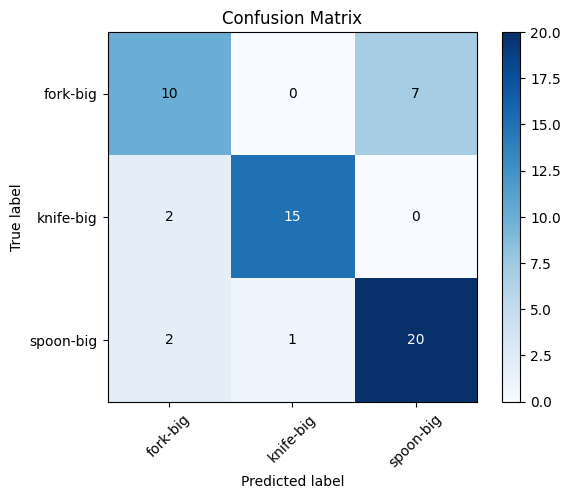

In [88]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(y_test_label,yhat_label,labels=sorted_class_labels,x_tick_rotation=45)

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [89]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

True     45
False    12
Name: count, dtype: int64

------------------------------
fork-big  : 59%
spoon-big : 87%
knife-big : 88%


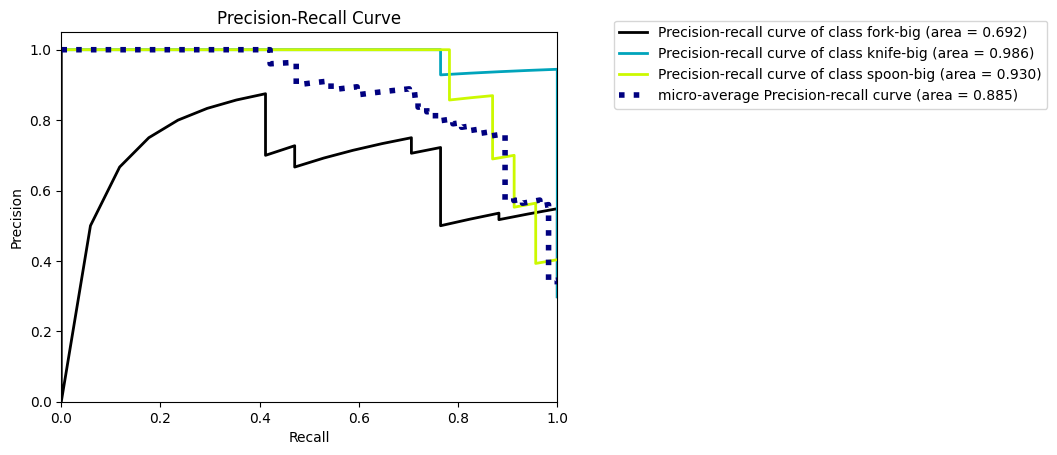

In [90]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

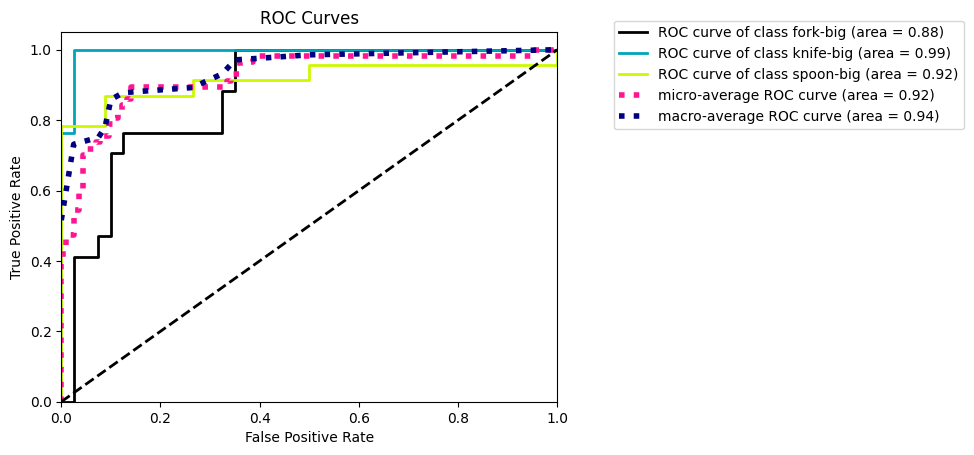

In [91]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [92]:
loaded_model 

<Functional name=Conv-Model-Standard, built=True>